In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

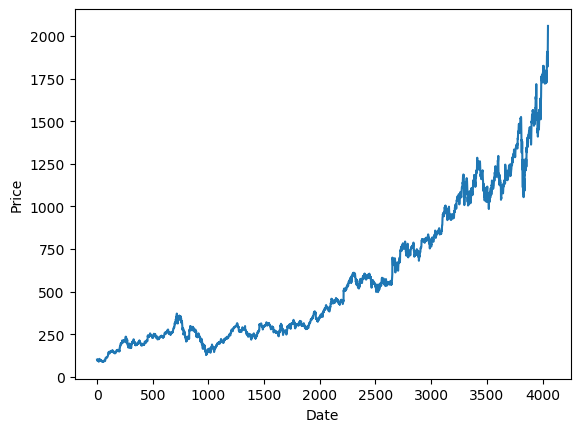

In [63]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime

stockName = "GOOGL"
stkTicker = yf.Ticker(stockName)
dataHist = stkTicker.history(start="2005-01-01", end=datetime.today().strftime('%Y-%m-%d'), interval = "1d")
dataClose = dataHist['Close'].to_numpy()
dataClose = dataClose.reshape(-1,1)
np.set_printoptions(threshold=np.inf)
plt.style.use("default")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dataClose)

In [64]:
# Preprocess the historical data
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  1-4044(4044)    dataClose   dataset                                              |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         datasetTrain                           |   datasetTest                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         0-2446  xTrain             | 2447-2546 |                                  |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|       0-99     |     100-2546     yTrain      |                                  |
# -----------------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ------------------x = Percentage--------------------
dataPer = []
dataPer.append(0)

for i in range(dataClose.size-1):
    dataPer.append(math.log(dataClose[i+1] / dataClose[i]))
    #if dataClose[i+1] >= dataClose[i]:
     #   dataPer.append(math.log(dataClose[i+1] / dataClose[i]))
    #else:
        #dataPer.append(0)
dataset = np.array(dataPer)
dataset = dataset.reshape(-1,1)

minmaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True)
_dataset = minmaxScaler.fit_transform(dataset)
print("The max =", minmaxScaler.data_max_,", the Min =",minmaxScaler.data_min_)

The max = [0.18225111] , the Min = [-0.12368463]


In [65]:
# Get train set and test set

sizeTrain = int(_dataset.size*0.63)
sizeTest = _dataset.size - sizeTrain
print("The length of data is:",_dataset.size, \
      "\nThe length of Training is:", sizeTrain, \
      "\nThe length of Testing is:", sizeTest)
_Train = _dataset[ : sizeTrain, : ]
_Test = _dataset[sizeTrain : , : ]

The length of data is: 4050 
The length of Training is: 2551 
The length of Testing is: 1499


In [66]:
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  0  |   1-4044(4044)                                                              |
# -----------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    datasetTrain                           |   datasetTest                    |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    0-2446  xTrain             | 2447-2546 |                                  |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |   0-99     |     100-2546     yTrain      |                                  |
#      ------------------------------------------------------------------------------

DIM_LSTM = 100

def formatData(dataSet,dimLSTM):
    X,Y = [],[]
    for i in range(dataSet.size - dimLSTM):
        X.append(dataSet[i : i+dimLSTM, : ])
        Y.append(dataSet[i + dimLSTM, : ])
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1,dimLSTM)
    Y = Y.reshape(-1,1)
    X = X.reshape(X.shape[0], X.shape[1],1)
    return X,Y
_xTrain, _yTrain = formatData(_Train, DIM_LSTM)
_xTest, _yTest = formatData(_Test, DIM_LSTM)
xTrain, yTrain = formatData(dataset[ : sizeTrain, : ], DIM_LSTM)
xTest, yTest = formatData(dataset[sizeTrain : , : ], DIM_LSTM)
xTrainClose, yTrainClose = formatData(dataClose[ : sizeTrain, : ], DIM_LSTM)
xTestClose, yTestClose = formatData(dataClose[sizeTrain : , : ], DIM_LSTM)

In [67]:
# Build the model

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

def my_loss_fn(y_true, y_pred):
    #base = tf.where(tf.logical_and(tf.greater_equal(y_pred,1), tf.greater_equal(y_true,1)), tf.zeros_like(y_true), tf.ones_like(y_true))
    #base = tf.where(tf.logical_and(tf.less(y_pred,1), tf.less(y_true,1)), tf.zeros_like(y_true), base)
    #base = tf.where(tf.logical_and(tf.greater_equal(y_pred,1), tf.less(y_true,1)), tf.math.negative(tf.math.log(y_true)), base)
    #base = tf.where(tf.logical_and(tf.less(y_pred,1), tf.greater_equal(y_true,1)), tf.math.log(y_true), base)
    base = tf.where(tf.logical_and(tf.greater_equal(y_pred,0), tf.greater_equal(y_true,0)), tf.zeros_like(y_true), tf.ones_like(y_true))
    base = tf.where(tf.logical_and(tf.less(y_pred,0), tf.less(y_true,0)), tf.zeros_like(y_true), base)
    base = tf.where(tf.logical_and(tf.greater_equal(y_pred,0), tf.less(y_true,0)), tf.math.negative(y_true), base)
    base = tf.where(tf.logical_and(tf.less(y_pred,0), tf.greater_equal(y_true,0)), y_true, base)
    loss = tf.square(base)
    return loss

UNIT_LSTM = 50
model = keras.Sequential()
model.add(LSTM(UNIT_LSTM, return_sequences = True, input_shape=(DIM_LSTM,1)))
model.add(LSTM(UNIT_LSTM, return_sequences = True))
model.add(LSTM(UNIT_LSTM))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Fit the model   
model.fit(_xTrain,_yTrain,validation_data=(_xTest,_yTest), epochs=100, batch_size=64, verbose =1)

Epoch 1/100
39/39 [==============================] - 8s 133ms/step - loss: 0.0351 - val_loss: 0.0034
Epoch 2/100
39/39 [==============================] - 5s 135ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/100
39/39 [==============================] - 5s 134ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 4/100
39/39 [==============================] - 5s 135ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/100
39/39 [==============================] - 6s 142ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 6/100
39/39 [==============================] - 5s 141ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 7/100
39/39 [==============================] - 5s 140ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 8/100
39/39 [==============================] - 5s 140ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 9/100
39/39 [==============================] - 5s 141ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 10/100
39/39 [==============================] - 5s 141ms/step - loss: 0.0043 - val_lo

39/39 [==============================] - 6s 156ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 82/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 83/100
39/39 [==============================] - 6s 156ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 84/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 85/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 86/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 87/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 88/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 89/100
39/39 [==============================] - 6s 155ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 90/100
39/39 [==============================] - 6s 156ms/step - loss: 0.0045 - val_loss: 

In [97]:
# Make predictions

from sklearn.metrics import mean_squared_error

_predTrain = model.predict(_xTrain)
_predTest= model.predict(_xTest)
predTrain = minmaxScaler.inverse_transform(_predTrain)
predTest = minmaxScaler.inverse_transform(_predTest)
mean_squared_error(predTrain,yTrain)

0.00038451112510619865

In [99]:
def disp_res(pred,close,lever,isPrint):
    pred = pred.flatten()
    j = 0
    for i in range(pred.size):
        if i == 0:
            gain = 1
        else:
            if predTrain[i]>0.000:
                j=j+1
                gain = gain * (close[i-1] + lever * (close[i]-close[i-1])) / close[i-1]
                if isPrint !=0:
                    print(i, "\tCurrClose:%.02f" %close[i], \
                             "  \tPredCurrGain%+.07f" %math.exp(pred[i]), \
                             "  \tActualGain%+.02f" %(close[i]/close[i-1]), \
                             "  \tPredLongTermGain%+.02f" %gain)
    if isPrint !=0:
        print("\n\n\nFinal gain comparasion:\t",gain,"rather than Long-Term-Gain",close[pred.size-1]/close[0],", Trading times",j)
    return gain
    
disp_res(predTrain,yTrainClose,3,1) 
    

1 	CurrClose:133.13   	PredCurrGain+1.0000425   	ActualGain+1.03   	PredLongTermGain+1.08
2 	CurrClose:138.77   	PredCurrGain+1.0001200   	ActualGain+1.04   	PredLongTermGain+1.22
3 	CurrClose:144.14   	PredCurrGain+1.0002097   	ActualGain+1.04   	PredLongTermGain+1.36
4 	CurrClose:144.09   	PredCurrGain+1.0003336   	ActualGain+1.00   	PredLongTermGain+1.36
5 	CurrClose:140.27   	PredCurrGain+1.0004618   	ActualGain+0.97   	PredLongTermGain+1.25
6 	CurrClose:145.62   	PredCurrGain+1.0005298   	ActualGain+1.04   	PredLongTermGain+1.39
7 	CurrClose:146.71   	PredCurrGain+1.0005482   	ActualGain+1.01   	PredLongTermGain+1.42
8 	CurrClose:139.92   	PredCurrGain+1.0005470   	ActualGain+0.95   	PredLongTermGain+1.22
9 	CurrClose:143.30   	PredCurrGain+1.0004805   	ActualGain+1.02   	PredLongTermGain+1.31
10 	CurrClose:141.39   	PredCurrGain+1.0003597   	ActualGain+0.99   	PredLongTermGain+1.26
11 	CurrClose:141.52   	PredCurrGain+1.0002135   	ActualGain+1.00   	PredLongTermGain+1.26
12 	Curr

array([1.29068099])

In [101]:
disp_res(predTest,yTestClose,4,1) 

1 	CurrClose:699.62   	PredCurrGain+0.9994478   	ActualGain+1.16   	PredLongTermGain+1.65
2 	CurrClose:692.84   	PredCurrGain+0.9997141   	ActualGain+0.99   	PredLongTermGain+1.59
3 	CurrClose:695.35   	PredCurrGain+1.0000754   	ActualGain+1.00   	PredLongTermGain+1.61
4 	CurrClose:695.10   	PredCurrGain+1.0004145   	ActualGain+1.00   	PredLongTermGain+1.61
5 	CurrClose:674.73   	PredCurrGain+1.0006706   	ActualGain+0.97   	PredLongTermGain+1.42
6 	CurrClose:654.77   	PredCurrGain+1.0007980   	ActualGain+0.97   	PredLongTermGain+1.25
7 	CurrClose:658.27   	PredCurrGain+1.0007727   	ActualGain+1.01   	PredLongTermGain+1.28
8 	CurrClose:659.66   	PredCurrGain+1.0006350   	ActualGain+1.00   	PredLongTermGain+1.29
9 	CurrClose:661.43   	PredCurrGain+1.0004455   	ActualGain+1.00   	PredLongTermGain+1.30
10 	CurrClose:664.56   	PredCurrGain+1.0002442   	ActualGain+1.00   	PredLongTermGain+1.33
11 	CurrClose:657.50   	PredCurrGain+1.0000565   	ActualGain+0.99   	PredLongTermGain+1.27
12 	Curr

array([1.25093571])

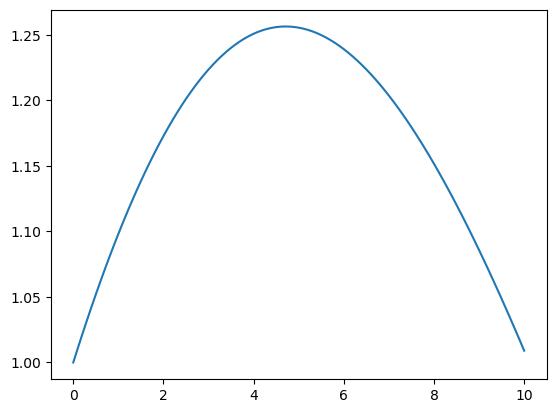

In [102]:
def disp_lever(pred,close,):
    disp  = []
    lever = []
    l = float(0)
    while l<=10:
        disp.append(disp_res(pred,close,l,0))
        lever.append(l)
        l=l+0.1
    disp = np.array(disp).reshape(-1,1)
    lever = np.array(lever).reshape(-1,1)
    plt.plot(lever, disp)

disp_lever(predTest,yTestClose)


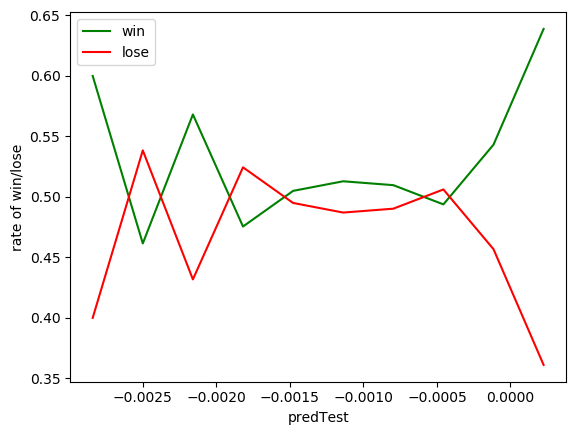

In [107]:
def disp_hist(pred,close):
    i = pred.min()
    _win = []
    _lose = []
    _i = []
    while i<= pred.max():
        win = 0
        lose = 0
        for j in range(1,pred.size,1):
            if pred[j] >= i and pred[j] < i+(pred.max()-pred.min())/10:
                if close[j] > close[j-1] :
                    win = win + 1                
                else:
                    lose = lose + 1
        _win.append(win/(win+lose))
        _lose.append(lose/(win+lose))
        _i.append(i)
        i=i+(pred.max()-pred.min())/10
        
    _win = np.array(_win).reshape(-1,1)
    _lose = np.array(_lose).reshape(-1,1)
    _i = np.array(_i).reshape(-1,1)
    plt.plot(_i, _win, color='green', label='win')
    plt.plot(_i, _lose, color='red', label='lose')
    plt.xlabel('predTest')
    plt.ylabel('rate of win/lose')
    plt.legend()
            
disp_hist(predTrain,yTrainClose)